In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow import set_random_seed
from keras.callbacks import EarlyStopping

from keras.models import Sequential
# sequential model, for linear stack of NN layers

from keras.layers import Dense, Dropout, Activation, Flatten
# Dense is a standard densely connected NN layer
# Dropout randomly drops a percentage, p, of the neurons from a layer (helps reduce overfitting)

from keras.layers import Conv2D, MaxPooling2D
# Convolution layers that help efficiently train image data

from keras.utils import np_utils
# used for transforming data

Using TensorFlow backend.


In [2]:
# read training and testing data
X_train = pd.read_pickle("../training_data/X_train.bz2").values
Y_train = pd.read_pickle("../training_data/Y_train.bz2").values
X_test = pd.read_pickle("../training_data/X_test.bz2").values
Y_test = pd.read_pickle("../training_data/Y_test.bz2").values

p = np.shape(X_train)[0] # number of training data
q = np.shape(X_test)[0] # number of test data

m = np.shape(X_train)[1]/2 # number of (T,cv) data
n = np.shape(Y_train)[1] # dimension of output vector

X_train = np.reshape(X_train, (p, 2, m, 1))
X_test = np.reshape(X_test, (q, 2, m, 1))

In [3]:
print X_train.shape
print Y_train.shape
(m,n)

(60000, 2, 128, 1)
(60000, 128)


(128, 128)

[14858 58823 13278 37470 46383]


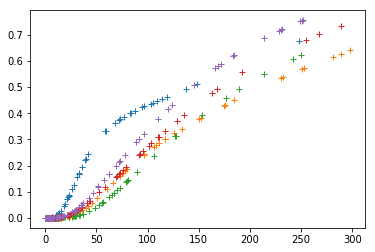

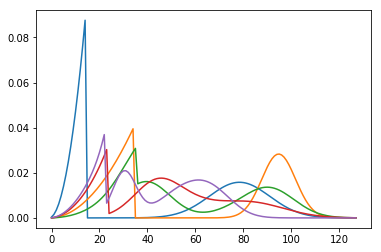

In [4]:
# check the loaded data
r = np.random.randint(0,p,5)
print r
for i in r:
    plt.figure(0)
    plt.plot(X_train[i][0],X_train[i][1],'+')
    plt.figure(1)
    plt.plot(Y_train[i])

In [5]:
# preprocess input data

# cv lies in the range [0,1], whereas T is in the range [0.1,300]
# we should feature scale T by dividing by 300 (typical maximum value for real data)

X_train[:,0,:,0] /= 300.
X_test[:,0,:,0] /= 300.
# normalize so values range between 0 and 1

[55680 11109 12249 24324 33720]


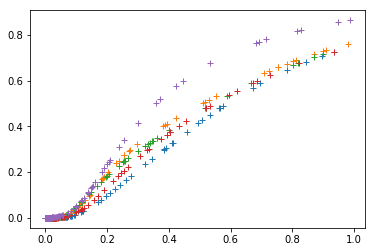

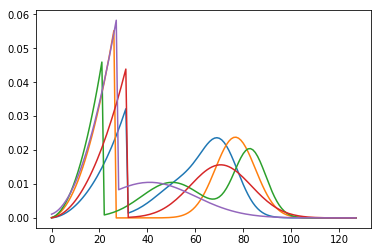

In [6]:
# check the processed data
r = np.random.randint(0,p,5)
print r
for i in r:
    plt.figure(0)
    plt.plot(X_train[i][0],X_train[i][1],'+')
    plt.figure(1)
    plt.plot(Y_train[i])

In [7]:
print X_train[0].shape

(2, 128, 1)


In [8]:
# set random seeds for repeatable behaviour
np.random.seed(140590)
set_random_seed(140590)

# here we define the model architecture
model = Sequential()

#input layer
model.add(Conv2D(32, (2, 2), activation='relu', input_shape=(2, 128, 1)))
print model.output_shape

model.add(MaxPooling2D(pool_size=(1,3)))
model.add(Dropout(0.25))
print model.output_shape

model.add(Flatten())
print model.output_shape

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
print model.output_shape

model.add(Dense(n, activation='softmax'))
print model.output_shape

(None, 1, 127, 32)
(None, 1, 42, 32)
(None, 1344)
(None, 128)
(None, 128)


In [9]:
#-----------------------------------------------------------------------------
# Define custom loss functions for regression in Keras 
#-----------------------------------------------------------------------------
#
# REF: https://github.com/keras-team/keras/issues/7947

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [10]:
# here we compile the model and define a loss function
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error', rmse, r_square])

In [11]:
# enabling early stopping based on mean_squared_error
earlystopping = EarlyStopping(monitor='mean_squared_error', patience=10, verbose=1, mode='auto')

In [12]:
# now we can fit the model
result = model.fit(X_train, Y_train, batch_size=32, epochs=240, verbose=1, validation_data=(X_test, Y_test), callbacks=[earlystopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/240
60000/60000 [==============================] - 17s 279us/step - loss: 8.8114e-05 - mean_squared_error: 8.8114e-05 - rmse: 0.0085 - r_square: 0.5263 - val_loss: 6.4510e-05 - val_mean_squared_error: 6.4510e-05 - val_rmse: 0.0073 - val_r_square: 0.6510
Epoch 2/240
60000/60000 [==============================] - 15s 249us/step - loss: 6.8112e-05 - mean_squared_error: 6.8112e-05 - rmse: 0.0075 - r_square: 0.6318 - val_loss: 5.6977e-05 - val_mean_squared_error: 5.6977e-05 - val_rmse: 0.0069 - val_r_square: 0.6915
Epoch 3/240
60000/60000 [==============================] - 11s 187us/step - loss: 6.3040e-05 - mean_squared_error: 6.3040e-05 - rmse: 0.0073 - r_square: 0.6594 - val_loss: 5.1657e-05 - val_mean_squared_error: 5.1657e-05 - val_rmse: 0.0066 - val_r_square: 0.7196
Epoch 4/240
60000/60000 [==============================] - 11s 178us/step - loss: 6.0607e-05 - mean_squared_error: 6.0607e-05 - rmse: 0.0071 - r_square: 0.6723 - va

Epoch 32/240
60000/60000 [==============================] - 15s 244us/step - loss: 5.1069e-05 - mean_squared_error: 5.1069e-05 - rmse: 0.0066 - r_square: 0.7230 - val_loss: 4.2048e-05 - val_mean_squared_error: 4.2048e-05 - val_rmse: 0.0060 - val_r_square: 0.7704
Epoch 33/240
60000/60000 [==============================] - 15s 249us/step - loss: 5.0889e-05 - mean_squared_error: 5.0889e-05 - rmse: 0.0066 - r_square: 0.7237 - val_loss: 4.0926e-05 - val_mean_squared_error: 4.0926e-05 - val_rmse: 0.0060 - val_r_square: 0.7765
Epoch 34/240
60000/60000 [==============================] - 15s 244us/step - loss: 5.0809e-05 - mean_squared_error: 5.0809e-05 - rmse: 0.0066 - r_square: 0.7239 - val_loss: 4.0565e-05 - val_mean_squared_error: 4.0565e-05 - val_rmse: 0.0059 - val_r_square: 0.7783
Epoch 35/240
60000/60000 [==============================] - 15s 250us/step - loss: 5.0780e-05 - mean_squared_error: 5.0780e-05 - rmse: 0.0066 - r_square: 0.7242 - val_loss: 4.1901e-05 - val_mean_squared_error: 4

60000/60000 [==============================] - 17s 278us/step - loss: 4.8845e-05 - mean_squared_error: 4.8845e-05 - rmse: 0.0065 - r_square: 0.7341 - val_loss: 3.9492e-05 - val_mean_squared_error: 3.9492e-05 - val_rmse: 0.0058 - val_r_square: 0.7837
Epoch 64/240
60000/60000 [==============================] - 18s 297us/step - loss: 4.8702e-05 - mean_squared_error: 4.8702e-05 - rmse: 0.0065 - r_square: 0.7351 - val_loss: 3.9853e-05 - val_mean_squared_error: 3.9853e-05 - val_rmse: 0.0059 - val_r_square: 0.7821
Epoch 65/240
60000/60000 [==============================] - 17s 290us/step - loss: 4.8618e-05 - mean_squared_error: 4.8618e-05 - rmse: 0.0064 - r_square: 0.7353 - val_loss: 3.9905e-05 - val_mean_squared_error: 3.9905e-05 - val_rmse: 0.0059 - val_r_square: 0.7814
Epoch 66/240
60000/60000 [==============================] - 17s 279us/step - loss: 4.8661e-05 - mean_squared_error: 4.8661e-05 - rmse: 0.0064 - r_square: 0.7350 - val_loss: 3.8355e-05 - val_mean_squared_error: 3.8355e-05 - v

60000/60000 [==============================] - 18s 300us/step - loss: 4.8062e-05 - mean_squared_error: 4.8062e-05 - rmse: 0.0064 - r_square: 0.7385 - val_loss: 3.7363e-05 - val_mean_squared_error: 3.7363e-05 - val_rmse: 0.0057 - val_r_square: 0.7953
Epoch 95/240
60000/60000 [==============================] - 16s 271us/step - loss: 4.7869e-05 - mean_squared_error: 4.7869e-05 - rmse: 0.0064 - r_square: 0.7395 - val_loss: 3.8104e-05 - val_mean_squared_error: 3.8104e-05 - val_rmse: 0.0058 - val_r_square: 0.7909
Epoch 96/240
60000/60000 [==============================] - 16s 271us/step - loss: 4.7755e-05 - mean_squared_error: 4.7755e-05 - rmse: 0.0064 - r_square: 0.7400 - val_loss: 3.7565e-05 - val_mean_squared_error: 3.7565e-05 - val_rmse: 0.0057 - val_r_square: 0.7936
Epoch 97/240
60000/60000 [==============================] - 17s 289us/step - loss: 4.7817e-05 - mean_squared_error: 4.7817e-05 - rmse: 0.0064 - r_square: 0.7397 - val_loss: 3.7265e-05 - val_mean_squared_error: 3.7265e-05 - v

60000/60000 [==============================] - 17s 280us/step - loss: 4.7282e-05 - mean_squared_error: 4.7282e-05 - rmse: 0.0064 - r_square: 0.7423 - val_loss: 3.6870e-05 - val_mean_squared_error: 3.6870e-05 - val_rmse: 0.0057 - val_r_square: 0.7975
Epoch 126/240
60000/60000 [==============================] - 17s 289us/step - loss: 4.7606e-05 - mean_squared_error: 4.7606e-05 - rmse: 0.0064 - r_square: 0.7411 - val_loss: 3.8378e-05 - val_mean_squared_error: 3.8378e-05 - val_rmse: 0.0057 - val_r_square: 0.7904
Epoch 127/240
60000/60000 [==============================] - 18s 294us/step - loss: 4.7400e-05 - mean_squared_error: 4.7400e-05 - rmse: 0.0064 - r_square: 0.7419 - val_loss: 3.8107e-05 - val_mean_squared_error: 3.8107e-05 - val_rmse: 0.0057 - val_r_square: 0.7915
Epoch 128/240
60000/60000 [==============================] - 21s 358us/step - loss: 4.7674e-05 - mean_squared_error: 4.7674e-05 - rmse: 0.0064 - r_square: 0.7406 - val_loss: 3.7874e-05 - val_mean_squared_error: 3.7874e-05 

60000/60000 [==============================] - 15s 256us/step - loss: 4.6811e-05 - mean_squared_error: 4.6811e-05 - rmse: 0.0063 - r_square: 0.7449 - val_loss: 3.7819e-05 - val_mean_squared_error: 3.7819e-05 - val_rmse: 0.0057 - val_r_square: 0.7929
Epoch 157/240
60000/60000 [==============================] - 16s 268us/step - loss: 4.7124e-05 - mean_squared_error: 4.7124e-05 - rmse: 0.0063 - r_square: 0.7433 - val_loss: 3.6096e-05 - val_mean_squared_error: 3.6096e-05 - val_rmse: 0.0056 - val_r_square: 0.8021
Epoch 158/240
60000/60000 [==============================] - 17s 281us/step - loss: 4.7039e-05 - mean_squared_error: 4.7039e-05 - rmse: 0.0063 - r_square: 0.7438 - val_loss: 3.6162e-05 - val_mean_squared_error: 3.6162e-05 - val_rmse: 0.0056 - val_r_square: 0.8016
Epoch 159/240
60000/60000 [==============================] - 16s 259us/step - loss: 4.6817e-05 - mean_squared_error: 4.6817e-05 - rmse: 0.0063 - r_square: 0.7450 - val_loss: 3.7169e-05 - val_mean_squared_error: 3.7169e-05 

In [ ]:
# get predictions
Y_pred = model.predict(X_test)

In [ ]:
# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(result.history['r_square'])
plt.plot(result.history['val_r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
           
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# print statistical figures of merit

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(Y_test,Y_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(Y_test,Y_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(Y_test,Y_pred)))
print("R square (sklearn) (R^2):       %f" % sklearn.metrics.r2_score(Y_test,Y_pred))
print("R square (R^2):                 %f" % backend.eval(r_square(backend.variable(Y_test),backend.variable(Y_pred))))

In [ ]:
i = np.random.randint(0,q)
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.show()

In [ ]:
i = 908
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.axis([0,30,0,0.15])
plt.show()

i = 5295
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.axis([0,100,0,0.06])
plt.show()

i = 8825
print i

plt.plot(Y_pred[i])
plt.plot(Y_test[i])
plt.legend(['pred', 'real'], loc='upper right')
plt.axis([0,100,0,0.06])
plt.show()

In [ ]:
# save model architecture, weights, training config, and state to HD5 file
model.save('./hc-CNN_001_NAdam_MSE_e240_b32.h5')

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')